In [1]:
import os
import sys
import random
import warnings
import torch

from pathlib import Path
from IPython.display import SVG, display
from IPython.core.display import HTML

from torch.utils.data import DataLoader

### Enable Hot Reload

In [2]:
%load_ext autoreload
%autoreload 2

### Edit Python path
Add the `models` directory to Python's `path`.

In [3]:
b_paths = [os.path.abspath(os.path.join('..', '..')), os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('..', 'scripts'))]
for b_path in b_paths:
    if b_path not in sys.path:
        sys.path.append(b_path)

BASE_DIR = Path(os.getcwd()).parent.parent.resolve()
%cd $BASE_DIR

I:\My Drive\master_thesis_experiments\stroke2postfix-transformer


### Ignore Warnings

In [4]:
warnings.filterwarnings('ignore')
display(HTML("<style>.container {width:80% !important;}</style>"))

### Import Helpers

In [5]:
from models.scripts.transformer.ExprTree_model import model_builder, pad_collate_fn
from models.scripts.transformer.utils import strokes_to_svg, build_vocab, tensor_to_word, preprocess_dataset, seed_all, initialize_weights
from models.scripts.generate_arithmetic_sequences import SequenceGenerator

### Configuration Settings

In [6]:
VERSION = "v11"
SEED = 2021
BATCH_SIZE = 256

In [7]:
seed_all(SEED) # Reproducibility

### Create Vocabulary

In [8]:
DIGITS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
OPERATORS = ['+', '-', '*', '/']
DECIMAL_NOTATION = ['.']
BRACKETS = ['(', ')']
EQUAL_SIGN = ['=']
SEPARATOR = [',']
nums = DIGITS + OPERATORS + DECIMAL_NOTATION + BRACKETS + EQUAL_SIGN + SEPARATOR  #train labels

In [9]:
VOCAB = build_vocab(nums)

N_TOKENS = len(VOCAB)
PAD_IDX = VOCAB['<pad>']
BOS_IDX = VOCAB['<bos>']
EOS_IDX = VOCAB['<eos>']

print(f"Number of Tokens: {N_TOKENS}\n")
print(VOCAB.freqs, "\n") # Distribution
print({VOCAB.itos[i]: i for i in range(N_TOKENS)}) # Token order

Number of Tokens: 23

Counter({'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '+': 1, '-': 1, '*': 1, '/': 1, '.': 1, '(': 1, ')': 1, '=': 1, ',': 1}) 

{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, '=': 22}


### Generate Datasets

In [10]:
d_gen = SequenceGenerator(
        vocab = VOCAB,
        allow_brackets = True,
        save_mode = 'marked_postfix',      # saves expressions in RPN
        total_expressions = 120 * 1000  #final number of expressions is this*augmentation amount
      )
use_cache = True

if use_cache: # Generate from cache file
    train, valid, test = d_gen.generate_from_cache()

else: # Generate from scratch and cache (if regenerated, results could change)
    train, valid, test = d_gen.generate()

Using cached dataset file in cache\expressions_cache\expressions_120k_mb.h5


### Create Dataset for PyTorch

In [ ]:
preprocessed_train = preprocess_dataset(train, VOCAB,  os.path.join(d_gen.fname, "train.pt"))
preprocessed_valid = preprocess_dataset(valid, VOCAB,  os.path.join(d_gen.fname, "valid.pt"))

In [ ]:
train_set = DataLoader(preprocessed_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate_fn)
valid_set = DataLoader(preprocessed_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

### Inspect Generated Data

In [ ]:
# Get random index
x_dummy, y_dummy = next(iter(valid_set)) # Create dummy for visualization
ind = random.choice(range(y_dummy.shape[0]))
print("Index:", ind)

# Show actual expr for first tensor
print(" ".join(tensor_to_word(y_dummy[ind], VOCAB)), "\n")

# Get length of subplot depending on granularity (exclude bos/eos for strokes)
svg_str = strokes_to_svg(x_dummy[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

print()
print("Y Shape:", y_dummy.shape)
print("X Shape:", x_dummy.shape)
print()
print(f'Y[{ind}]:', y_dummy[ind])
print(f'X[{ind}]:', x_dummy[ind])
print()
print(f'X[{ind}][2]:', x_dummy[ind][2])

In [12]:
model= model_builder(name=VERSION, vocab=VOCAB, n_tokens=N_TOKENS, encoder='v74-bpe', decoder='v10')
model.save_hyperparameters_to_json()
model.count_parameters()
print(f"Encoder trainable parameters: {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,}.")
print(f"Decoder trainable parameters: {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,}.")
print("\n\n\n", model)

The model has 1,457,943 trainable parameters.
Encoder trainable parameters: 523,520.
Decoder trainable parameters: 934,423.



 Transformer(
  (encoder): Encoder(
    (pos_embedding): Embedding(200, 128)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_f

### Loss/Optimization configuration

In [ ]:
CLIP = 1
# BATCH_N0 = 4
NUM_OF_EPOCHS = 8000

LEARNING_RATE =3e-5
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

Adjusting learning rate of group 0 to 3.0000e-05.


### Training process along with best-model caching

In [ ]:
model.train_loop(resume=False,
                 train_set=train_set,
                 valid_set=valid_set,
                 optimizer=optimizer,
                 scheduler=scheduler)

### Plot Training  Logs

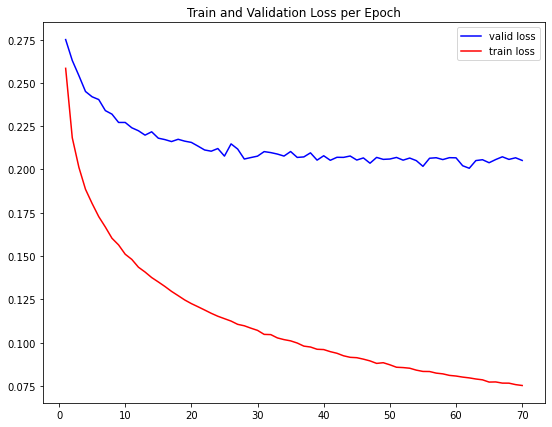

In [ ]:
model.plot_training()